## Statistic-Focused Fitting
> Example driven review and analysis fo how fitting model to a specific selection of phenomena helps clarify model llimitations. Useful for establishing that model can or cannot account for the considered effect in principle. But limited, even in aggregate, as measure of overall performance.

## Setup

In [1]:
#| code-summary: code -- load dependencies and data

from compmemlearn.models import Classic_CMR
from compmemlearn.fitting import apply_and_concatenate
from compmemlearn.datasets import prepare_murdock1970_data
from compmemlearn.datasets import simulate_array, simulate_df
from compmemlearn.analyses import plot_spc, plot_lag_crp, plot_pfr
from compmemlearn.analyses import fast_spc, fast_crp, fast_pfr
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit, literal_unroll, prange
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore', 'First-class function type feature is experimental')

murd_trials0, murd_events0, murd_length0 = prepare_murdock1970_data(
    '../../data/mo1970.txt')

In [2]:
@njit(nogil=True)
def murdock_mse(
    data_to_fit, item_counts, statistics, model_class, parameters):
    pooled_result = 0.0
    for i in range(len(item_counts)):
        
        # configure model
        item_count = item_counts[i]
        trials = data_to_fit[i]
        model = model_class(item_count, item_count, parameters)
        
        # generate simulation data from model
        sim_trials = simulate_array(model, len(trials)*10)
        
        # collect MSE for each relevant statistic
        result = 0
        for statistic in literal_unroll(statistics):
            simulation_outcome = statistic(sim_trials, item_count)
            data_outcome = statistic(trials, item_count)
            
            result += np.nanmean(np.square(simulation_outcome - data_outcome))
            
        # pool results across datasets
        pooled_result += result/len(statistics)
    
    return pooled_result/len(item_counts)

def murdock_mse_objective_function(
    data_to_fit, item_counts, statistics, model_class, fixed_parameters, free_parameters):

    parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
    for name, value in fixed_parameters.items():
        parameters[name] = value
    
    def objective_function(x):
        for i in range(len(free_parameters)):
            parameters[free_parameters[i]] = x[i]
        return murdock_mse(
            data_to_fit, item_counts, statistics, model_class, parameters)

    return objective_function

## Testing

### Data Simulation

In [3]:
cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

cmr_result = np.array(
    [5.84259066e-01, 4.27375824e-03, 7.21454638e-01, 8.17704509e-01,
     1.00000000e+00, 9.88623591e-02, 9.31571732e+00, 7.54040329e+01,
     3.14204629e-02, 3.36598109e-01, 9.99452206e+00, 9.95457387e-01])

fitted_parameters = Dict.empty(
    key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_array = simulate_array(model, 1000)

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_df = simulate_df(model, 1000)

In [4]:
sim_array, sim_df.head()

(array([[20, 14, 18, ...,  0,  0,  0],
        [16, 19,  5, ...,  0,  0,  0],
        [20, 18,  4, ...,  0,  0,  0],
        ...,
        [ 1,  2,  3, ...,  0,  0,  0],
        [19, 17, 20, ...,  0,  0,  0],
        [20, 19, 11, ...,  0,  0,  0]]),
    subject  list  item  input  output  study  recall  repeat  intrusion
 0        0     0     0      1     1.0   True    True       0      False
 1        0     0     1      2     2.0   True    True       0      False
 2        0     0     2      3     NaN   True   False       0      False
 3        0     0     3      4     4.0   True    True       0      False
 4        0     0     4      5     5.0   True    True       0      False)

### Summary Statistics

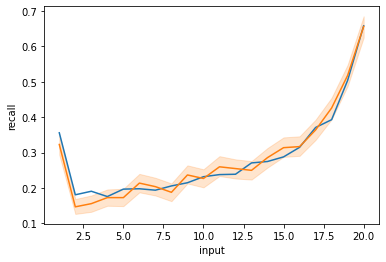

In [5]:
plt.plot(np.arange(20)+1, fast_spc(sim_array, murd_length0))
plot_spc(sim_df)

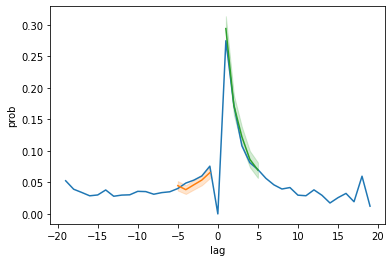

In [6]:
plt.plot(np.arange(-(model.item_count-1), model.item_count), fast_crp(sim_array, murd_length0))
plot_lag_crp(sim_df)

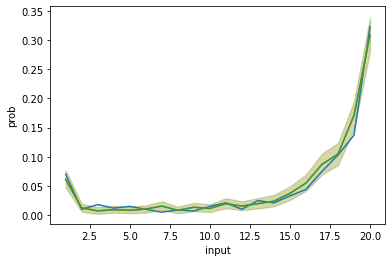

In [7]:
plt.plot(np.arange(20)+1, fast_pfr(sim_array, murd_length0))
plot_pfr(sim_df)

### MSE

In [8]:
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

murdock_mse((murd_trials0, ), (20, ), (fast_spc, ), init_cmr, fitted_parameters)

0.00589044391396605

In [9]:
murdock_mse((sim_array, ), (20, ), (fast_spc, ), init_cmr, fitted_parameters)

0.00034619199999999983

In [10]:
murdock_mse((sim_array, ), (20, ), (fast_crp, ), init_cmr, fitted_parameters)

5.807387526196056e-05

In [11]:
murdock_mse((murd_trials0, ), (20, ), (fast_spc, fast_crp), init_cmr, fitted_parameters)

C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
c:\programdata\miniconda3\lib\site-packages\numba\core\untyped_passes.py:1321: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return range(len(a))


0.0034331198222207265

## PFR Fitting

In [48]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_pfr, ),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

differential_evolution step 1: f(x)= 0.00227877
differential_evolution step 2: f(x)= 0.0022416
differential_evolution step 3: f(x)= 0.0022416
differential_evolution step 4: f(x)= 0.00172878
differential_evolution step 5: f(x)= 0.00172878
differential_evolution step 6: f(x)= 0.0014487
differential_evolution step 7: f(x)= 0.00109931
differential_evolution step 8: f(x)= 0.00109931
differential_evolution step 9: f(x)= 0.00109931
differential_evolution step 10: f(x)= 0.00109931
differential_evolution step 11: f(x)= 0.00109931
differential_evolution step 12: f(x)= 0.00109931
differential_evolution step 13: f(x)= 0.000728287
differential_evolution step 14: f(x)= 0.000728287
differential_evolution step 15: f(x)= 0.000728287
differential_evolution step 16: f(x)= 0.000728287
differential_evolution step 17: f(x)= 0.000728287
differential_evolution step 18: f(x)= 0.000702774
differential_evolution step 19: f(x)= 0.000702774
differential_evolution step 20: f(x)= 0.000702774
differential_evolution s

In [49]:
#| include: false
print(cmr_result)

     fun: 0.00040690417631172843
 message: 'Optimization terminated successfully.'
    nfev: 6599
     nit: 34
 success: True
       x: array([2.66061927e-01, 9.88047239e-02, 7.87233812e-03, 8.42613685e-02,
       5.61149906e-01, 3.70149424e-01, 6.91684222e-01, 2.07501561e+01,
       1.44832110e-02, 5.40135373e+00, 9.57148912e+00, 4.68623268e-02])


In [50]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_df(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

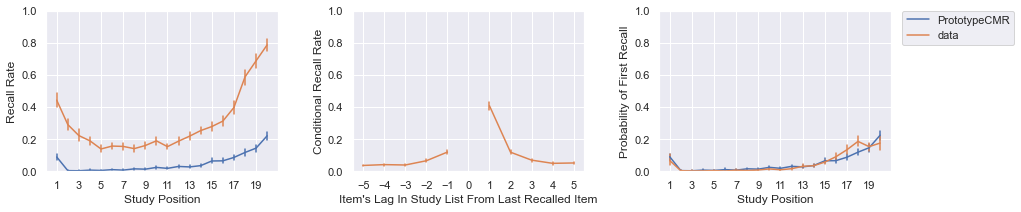

In [51]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[2], hue='source')
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## SPC Fitting

In [52]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_spc, ),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

differential_evolution step 1: f(x)= 0.0373309
differential_evolution step 2: f(x)= 0.0201125
differential_evolution step 3: f(x)= 0.0201125
differential_evolution step 4: f(x)= 0.0201125
differential_evolution step 5: f(x)= 0.0192122
differential_evolution step 6: f(x)= 0.0192122
differential_evolution step 7: f(x)= 0.00634495
differential_evolution step 8: f(x)= 0.00634495
differential_evolution step 9: f(x)= 0.00634495
differential_evolution step 10: f(x)= 0.00634495
differential_evolution step 11: f(x)= 0.00634495
differential_evolution step 12: f(x)= 0.00634495
differential_evolution step 13: f(x)= 0.00525577
differential_evolution step 14: f(x)= 0.00525577
differential_evolution step 15: f(x)= 0.0040069
differential_evolution step 16: f(x)= 0.0040069
differential_evolution step 17: f(x)= 0.0040069
differential_evolution step 18: f(x)= 0.0040069
differential_evolution step 19: f(x)= 0.00320019
differential_evolution step 20: f(x)= 0.00272058
differential_evolution step 21: f(x)= 0

In [53]:
#| include: false
print(cmr_result)

     fun: 0.0008275711323302468
 message: 'Optimization terminated successfully.'
    nfev: 13105
     nit: 70
 success: True
       x: array([7.73985968e-01, 1.03188757e-03, 9.32336688e-01, 3.41294714e-01,
       3.70477094e-01, 7.62765189e-01, 2.84696131e+01, 3.74746425e+01,
       3.76119943e-02, 2.89529280e-01, 6.00195889e+00, 2.27392392e-01])


In [54]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_df(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

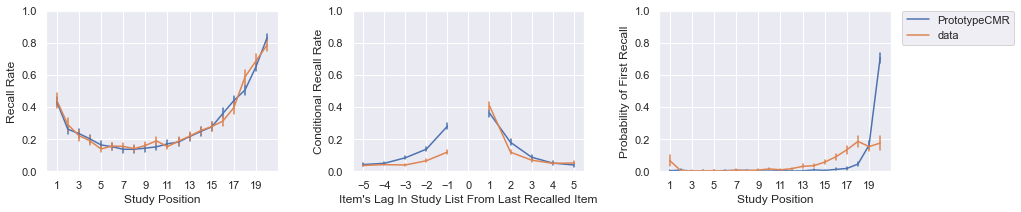

In [55]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[2], hue='source')
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## CRP Fitting

In [56]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_crp, ),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

differential_evolution step 1: f(x)= 0.00104697
differential_evolution step 2: f(x)= 0.00104697
differential_evolution step 3: f(x)= 0.000966318
differential_evolution step 4: f(x)= 0.000966318
differential_evolution step 5: f(x)= 0.000962475
differential_evolution step 6: f(x)= 0.000962475
differential_evolution step 7: f(x)= 0.000568189
differential_evolution step 8: f(x)= 0.000333549
differential_evolution step 9: f(x)= 0.000333549
differential_evolution step 10: f(x)= 0.000333549
differential_evolution step 11: f(x)= 0.000333549
differential_evolution step 12: f(x)= 0.000333549
differential_evolution step 13: f(x)= 0.000333549
differential_evolution step 14: f(x)= 0.000333549
differential_evolution step 15: f(x)= 0.000333549
differential_evolution step 16: f(x)= 0.000333549
differential_evolution step 17: f(x)= 0.000333549
differential_evolution step 18: f(x)= 0.000333549
differential_evolution step 19: f(x)= 0.000333549
differential_evolution step 20: f(x)= 0.000333549
differentia

In [57]:
#| include: false
print(cmr_result)

     fun: 0.00023227763230406628
 message: 'Optimization terminated successfully.'
    nfev: 6699
     nit: 36
 success: True
       x: array([ 0.80552751,  0.24685445,  0.99619296,  0.56771648,  0.88711938,
        0.11921944,  9.33572725, 27.2258657 ,  0.04008417,  1.76279596,
        5.20185253,  0.35508019])


In [58]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_df(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

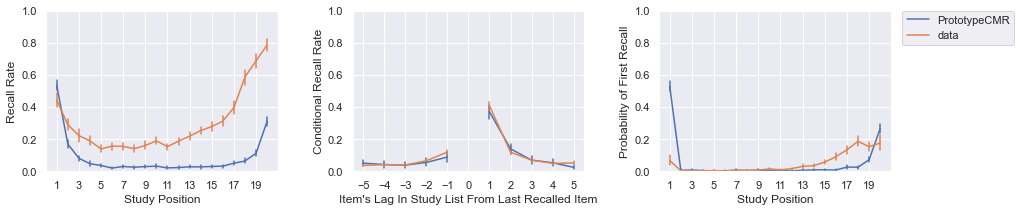

In [59]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[2], hue='source')
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## PFR + SPC Fitting

In [60]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_pfr, fast_spc),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
c:\programdata\miniconda3\lib\site-packages\numba\core\untyped_passes.py:1321: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return range(len(a))


differential_evolution step 1: f(x)= 0.0137953
differential_evolution step 2: f(x)= 0.0137953
differential_evolution step 3: f(x)= 0.0137953
differential_evolution step 4: f(x)= 0.0137953
differential_evolution step 5: f(x)= 0.0137953
differential_evolution step 6: f(x)= 0.0136085
differential_evolution step 7: f(x)= 0.0136085
differential_evolution step 8: f(x)= 0.008039
differential_evolution step 9: f(x)= 0.008039
differential_evolution step 10: f(x)= 0.00508187
differential_evolution step 11: f(x)= 0.00508187
differential_evolution step 12: f(x)= 0.00508187
differential_evolution step 13: f(x)= 0.00508187
differential_evolution step 14: f(x)= 0.00508187
differential_evolution step 15: f(x)= 0.00508187
differential_evolution step 16: f(x)= 0.00508187
differential_evolution step 17: f(x)= 0.00207465
differential_evolution step 18: f(x)= 0.00207465
differential_evolution step 19: f(x)= 0.00207465
differential_evolution step 20: f(x)= 0.00207465
differential_evolution step 21: f(x)= 0.

In [61]:
#| include: false
print(cmr_result)

     fun: 0.0008163061824845678
 message: 'Optimization terminated successfully.'
    nfev: 12051
     nit: 64
 success: True
       x: array([5.86142727e-01, 5.76568427e-01, 1.20906502e-02, 1.65257386e-01,
       8.17111472e-01, 5.95228510e-01, 2.25410644e-01, 5.40498150e+01,
       3.73803360e-02, 2.85258183e-01, 2.96301219e+00, 2.18643789e-01])


In [62]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_df(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

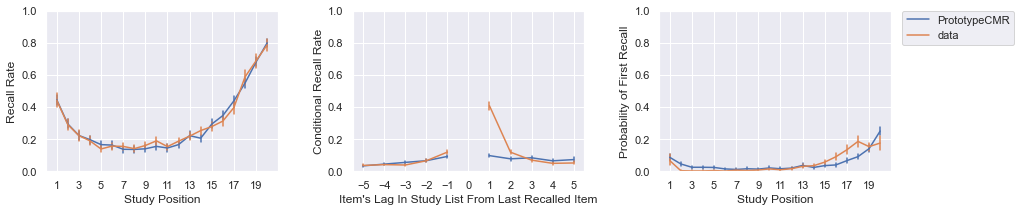

In [63]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[2], hue='source')
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## PFR + CRP Fitting

In [64]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_pfr, fast_crp),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
c:\programdata\miniconda3\lib\site-packages\numba\core\untyped_passes.py:1321: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return range(len(a))


differential_evolution step 1: f(x)= 0.00281649
differential_evolution step 2: f(x)= 0.00281649
differential_evolution step 3: f(x)= 0.00183991
differential_evolution step 4: f(x)= 0.00183991
differential_evolution step 5: f(x)= 0.00179259
differential_evolution step 6: f(x)= 0.00179259
differential_evolution step 7: f(x)= 0.00179259
differential_evolution step 8: f(x)= 0.00179259
differential_evolution step 9: f(x)= 0.00140089
differential_evolution step 10: f(x)= 0.00140089
differential_evolution step 11: f(x)= 0.00140089
differential_evolution step 12: f(x)= 0.00140089
differential_evolution step 13: f(x)= 0.00140089
differential_evolution step 14: f(x)= 0.00140089
differential_evolution step 15: f(x)= 0.00140089
differential_evolution step 16: f(x)= 0.00140089
differential_evolution step 17: f(x)= 0.00140089
differential_evolution step 18: f(x)= 0.000990803
differential_evolution step 19: f(x)= 0.000990803
differential_evolution step 20: f(x)= 0.000990803
differential_evolution ste

In [65]:
#| include: false
print(cmr_result)

     fun: 0.0008347682380325926
     jac: array([ -863.12827064,  4833.67751395,  -971.09918723,  5097.68073843,
        3505.13504216,  1276.67870408,  -851.09200675,  1609.60195012,
       -3462.73620645,  -411.311785  , -1420.3770348 ,  1612.36369059])
 message: 'Optimization terminated successfully.'
    nfev: 7191
     nit: 37
 success: True
       x: array([5.46507339e-01, 9.78249208e-02, 8.65803392e-01, 5.07618423e-01,
       8.66948577e-02, 7.84192145e-03, 9.56156170e-01, 6.44160596e+01,
       3.89488063e-02, 6.54789871e-01, 8.35062071e+00, 8.44615912e-01])


In [66]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_df(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

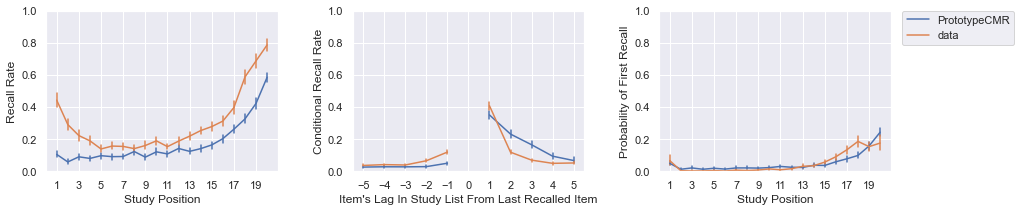

In [67]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[2], hue='source')
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## SPC + CRP Fitting

In [68]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_crp, fast_spc),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
c:\programdata\miniconda3\lib\site-packages\numba\core\untyped_passes.py:1321: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return range(len(a))


differential_evolution step 1: f(x)= 0.0191786
differential_evolution step 2: f(x)= 0.0191786
differential_evolution step 3: f(x)= 0.0115876
differential_evolution step 4: f(x)= 0.0115876
differential_evolution step 5: f(x)= 0.0115876
differential_evolution step 6: f(x)= 0.00727415
differential_evolution step 7: f(x)= 0.00412873
differential_evolution step 8: f(x)= 0.00333167
differential_evolution step 9: f(x)= 0.00333167
differential_evolution step 10: f(x)= 0.00333167
differential_evolution step 11: f(x)= 0.00333167
differential_evolution step 12: f(x)= 0.00333167
differential_evolution step 13: f(x)= 0.00321288
differential_evolution step 14: f(x)= 0.00320486
differential_evolution step 15: f(x)= 0.00320486
differential_evolution step 16: f(x)= 0.00320486
differential_evolution step 17: f(x)= 0.00320486
differential_evolution step 18: f(x)= 0.00320486
differential_evolution step 19: f(x)= 0.00320486
differential_evolution step 20: f(x)= 0.00222398
differential_evolution step 21: f(

In [69]:
#| include: false
print(cmr_result)

     fun: 0.0009242268137526041
 message: 'Optimization terminated successfully.'
    nfev: 11433
     nit: 61
 success: True
       x: array([6.57002872e-01, 1.25009865e-02, 9.02579859e-01, 4.23572250e-01,
       7.79147154e-02, 2.01461189e-01, 2.01408948e+01, 1.16970769e+01,
       1.01474479e-02, 5.57519843e-01, 8.81829075e+00, 2.46678979e-01])


In [70]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_df(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

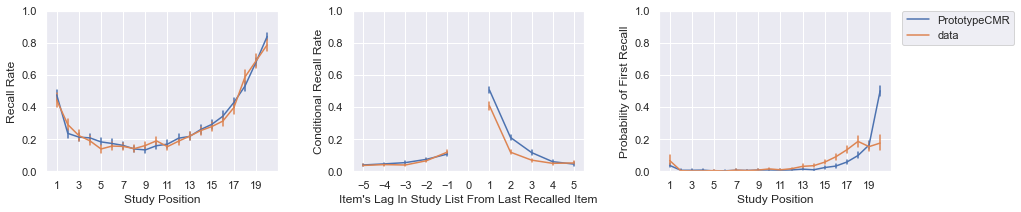

In [71]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[2], hue='source')
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## PFR + SPC + CRP Fitting

In [44]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_pfr, fast_spc, fast_crp),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_11152/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
c:\programdata\miniconda3\lib\site-packages\numba\core\untyped_passes.py:1321: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return range(len(a))


differential_evolution step 1: f(x)= 0.0248929
differential_evolution step 2: f(x)= 0.0192295
differential_evolution step 3: f(x)= 0.0147919
differential_evolution step 4: f(x)= 0.0112568
differential_evolution step 5: f(x)= 0.0112568
differential_evolution step 6: f(x)= 0.00761899
differential_evolution step 7: f(x)= 0.00761899
differential_evolution step 8: f(x)= 0.00620479
differential_evolution step 9: f(x)= 0.00620479
differential_evolution step 10: f(x)= 0.00620479
differential_evolution step 11: f(x)= 0.00611873
differential_evolution step 12: f(x)= 0.00465309
differential_evolution step 13: f(x)= 0.00465309
differential_evolution step 14: f(x)= 0.00465309
differential_evolution step 15: f(x)= 0.00415233
differential_evolution step 16: f(x)= 0.00415233
differential_evolution step 17: f(x)= 0.00415233
differential_evolution step 18: f(x)= 0.00415233
differential_evolution step 19: f(x)= 0.00415233
differential_evolution step 20: f(x)= 0.00304159
differential_evolution step 21: f(

In [45]:
#| include: false
print(cmr_result)

     fun: 0.0020215221818871364
 message: 'Optimization terminated successfully.'
    nfev: 12333
     nit: 66
 success: True
       x: array([5.33346446e-01, 2.90848598e-01, 8.39720971e-01, 3.11763030e-01,
       9.59405165e-01, 1.94094638e-02, 1.90960966e+00, 9.74803594e+01,
       2.22948291e-02, 4.16104071e-01, 5.46915726e+00, 6.51728536e-01])


In [46]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_df(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

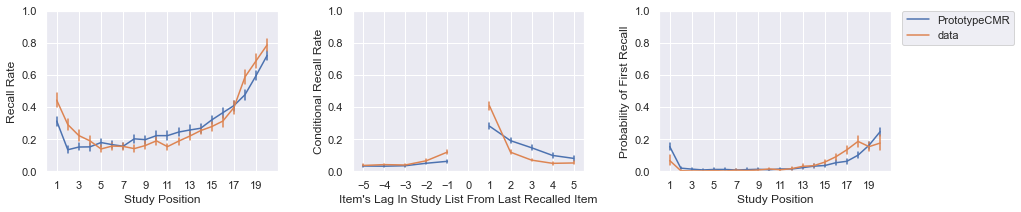

In [47]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[2], hue='source')
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')